## PRÁCTICA AUDIO
#### MIREN OSTOLAZA Y MARÍA GARCÍA

El objetivo de esta práctica será analizar diferentes audios que pertenecen a 7 clases diferentes haciendo referencia cada  una a una emoción humana:
  * Angry
  * Disgusted
  * Fearful
  * Happy
  * Neutral
  * Sad
  * Surprised
  
Una vez se ha realizado un análisis del dataset, se generará un modelo de clasificación con el fin de relacionar un audio a la emoción que se pueda detectar del mismo.

In [5]:
import librosa
from librosa import display
import os
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import IPython 
from IPython.display import display

from tqdm import tqdm
from matplotlib import cm, colors, pyplot as plt
from matplotlib.colors import ListedColormap
import librosa 
import librosa.display
import random

import tensorflow as tf
import tensorflow.python.keras as k

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [6]:
path = './Emotions'
lst = []
i = -2
start_time = time.time()

for subdir, dirs, files in os.walk(path):
  i=i+1
  print(subdir)
  print(i)
  for file in files:

        #Load librosa array, obtain mfcss, add them to array and then to list.
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=40).T,axis=0) 
        arr = mfccs, i
        lst.append(arr) #Here we append the MFCCs to our list.

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

./Emotions
-1
./Emotions\Angry
0
./Emotions\Disgusted
1
./Emotions\Fearful
2
./Emotions\Happy
3
./Emotions\Neutral
4
./Emotions\Sad
5
./Emotions\Suprised
6
--- Data loaded. Loading time: 881.3080389499664 seconds ---


# VISUALIZATION OF AUDIO

Para obtener más información sobre los audios que se van a analizar, se visualizan dichos audios de forma gráfica para poder plasmar sus caracteristicas como la amplitud,la frecuencia o el timbre. Como el dataset con el que se trabajará consta de varios audios pertenecientes a diferentes clases, se ha seleccionado un audio por cada clase o emoción para poder analizar mejor las diferencias entre ellos. 

In [7]:
import librosa
angry = './Emotions/Angry/03-01-05-01-01-01-02.wav'
disgusted = './Emotions/Disgusted/03-01-07-01-01-01-01.wav'
fearful = './Emotions/Fearful/03-01-06-01-01-01-01.wav'
happy = './Emotions/Happy/03-01-03-01-01-01-01.wav'
neutral = './Emotions/Neutral/03-01-01-01-01-01-02.wav'
sad = './Emotions/Sad/03-01-04-01-01-01-01.wav'
suprised = './Emotions/Suprised/03-01-08-01-01-01-01.wav'


x_angry , sr_angry = librosa.load(angry,sr=22050)
x_disgusted , sr_disgusted = librosa.load(disgusted)
x_fearful , sr_fearful = librosa.load(fearful)
x_happy , sr_happy = librosa.load(happy)
x_neutral , sr_neutral = librosa.load(neutral)
x_sad , sr_sad = librosa.load(sad)
x_suprised , sr_suprised = librosa.load(suprised)


Todos los audios se componene de la misma frase con connotaciones diferentes respecto a la entonación, de forma que simulan diferentes estados de ánimo. 

A continuación, se reproduce el audio seleccionado de la clase angry como ejemplo para escuchar la frase que se repite en cada audio:

In [8]:
def play_signal(x, sr):
    return IPython.display.Audio(data = x, rate = sr)

play_signal(x_angry, sr_angry)


## Waveform

El sonido son vibraciones, pequeñas ondas de presión en el aire. Para representar esas ondas y su amplitud a continuación se muestran los gráficos llamados 'waveform' de la amplitud de una forma de onda por cada emoción.

Text(0.5, 1.0, 'Suprised')

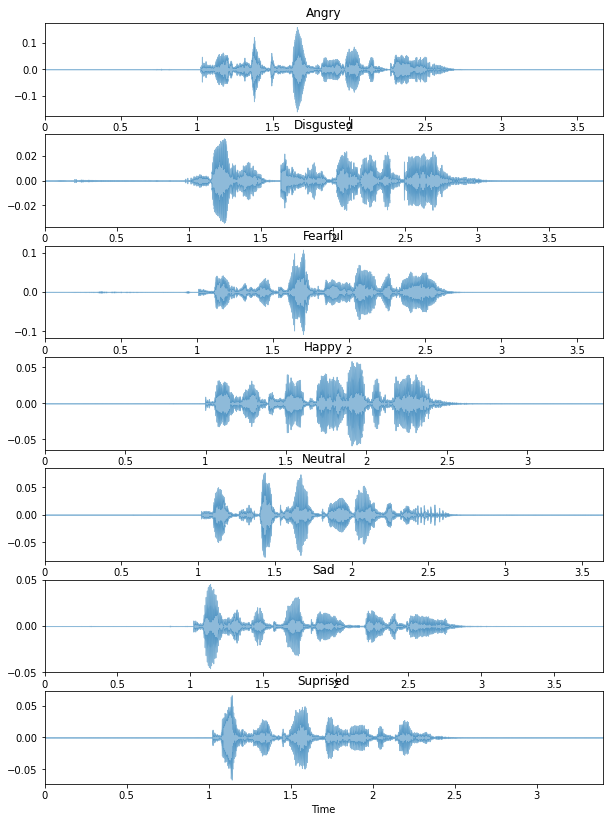

In [9]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display


plt.figure(figsize=(10, 14))
plt.subplot(7, 1, 1)
librosa.display.waveplot(x_angry, sr=sr_angry,alpha=0.5)
plt.title('Angry')
plt.subplot(7, 1, 2)
librosa.display.waveplot(x_disgusted, sr=sr_disgusted,alpha=0.5)
plt.title('Disgusted')
plt.subplot(7, 1, 3)
librosa.display.waveplot(x_fearful, sr=sr_fearful,alpha=0.5)
plt.title('Fearful')
plt.subplot(7, 1, 4)
librosa.display.waveplot(x_happy, sr=sr_happy,alpha=0.5)
plt.title('Happy')
plt.subplot(7, 1, 5)
librosa.display.waveplot(x_neutral, sr=sr_neutral,alpha=0.5)
plt.title('Neutral')
plt.subplot(7, 1, 6)
librosa.display.waveplot(x_sad, sr=sr_sad,alpha=0.5)
plt.title('Sad')
plt.subplot(7, 1, 7)
librosa.display.waveplot(x_suprised, sr=sr_suprised,alpha=0.5)
plt.title('Suprised')


Una vez se han representado los waveforms de cada clase del dataset se pueden apreciar ciertas diferencias y similitudes entre ellas. Por ejemplo, vemos que el audio de angry y disgusted son diferentes en cuanto sobre todo al inicio del audio. Sin embargo, podría decirse que angry y fearful comparten cierta similitud en cuanto a sample rate, así como sad y surprise. Por otro lado, también se puede apreciar que en todos os audios hay silencios al inicio y al final.

Además la amplitud de las ondas son distintas, se puede apreciar que las emociones de enfado y temerosidad tienen una amplitud más alta que las de disgusto, neutral, tristeza o sorpresa.

## Spectrum analysis

Lo siguiente fase será para conocer en mayor profundidad las frecuencias presentes en las grabaciones de audio que se están analizando. Para ello, lo primero será aplicar la transformada de Fourier tal y como se muestra a continuación. La transformada de Fourier con una señal es capaz de calcular qué frecuencias están presentes en ella. Es decir, convierte una señal en el dominio del tiempo a un dominio de la frecuencia.

Text(0.5, 1.0, 'Power spectrum of surprised')

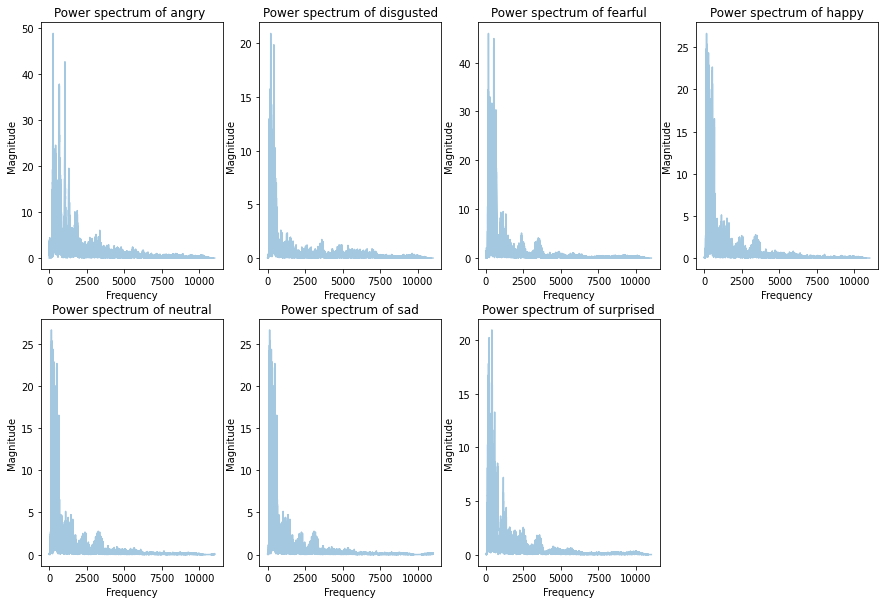

In [18]:
# Fourier transform

ff_angry =np.fft.fft(x_angry)
ff_disgusted = np.fft.fft(x_disgusted)
ff_fearful = np.fft.fft(x_fearful)
ff_happy = np.fft.fft(x_happy)
ff_neutral = np.fft.fft(x_neutral)
ff_sad = np.fft.fft(x_sad)
ff_suprised = np.fft.fft(x_suprised)

spectrum1 = np.abs(ff_angry)
spectrum2 = np.abs(ff_disgusted)
spectrum3 = np.abs(ff_fearful)
spectrum4 = np.abs(ff_happy)
spectrum5 = np.abs(ff_neutral)
spectrum6 = np.abs(ff_sad)
spectrum7 = np.abs(ff_suprised)

# Genera variable de frecuencia
f1 = np.linspace(0, sr_angry, len(spectrum1))
f2 = np.linspace(0, sr_disgusted, len(spectrum2))
f3 = np.linspace(0, sr_fearful, len(spectrum3))
f4 = np.linspace(0, sr_happy, len(spectrum4))
f5 = np.linspace(0, sr_neutral, len(spectrum5))
f6 = np.linspace(0, sr_sad, len(spectrum6))
f7 = np.linspace(0, sr_suprised, len(spectrum7))


left_spectrum1 = spectrum1[:int(len(spectrum1)/2)]
left_f1 = f1[:int(len(spectrum1)/2)]

left_spectrum2 = spectrum2[:int(len(spectrum2)/2)]
left_f2 = f2[:int(len(spectrum2)/2)]

left_spectrum3 = spectrum3[:int(len(spectrum3)/2)]
left_f3 = f3[:int(len(spectrum3)/2)]

left_spectrum4 = spectrum4[:int(len(spectrum4)/2)]
left_f4 = f4[:int(len(spectrum4)/2)]

left_spectrum5 = spectrum4[:int(len(spectrum5)/2)]
left_f5 = f5[:int(len(spectrum5)/2)]

left_spectrum6 = spectrum4[:int(len(spectrum6)/2)]
left_f6 = f6[:int(len(spectrum6)/2)]

left_spectrum7 = spectrum7[:int(len(spectrum7)/2)]
left_f7 = f7[:int(len(spectrum7)/2)]

fig = plt.figure(figsize=(15,10))
plt.subplot(2, 4, 1)

plt.plot(left_f1, left_spectrum1, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of angry ")

plt.subplot(2, 4,2)

plt.plot(left_f2, left_spectrum2, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of disgusted")
 
plt.subplot(2, 4, 3)
plt.plot(left_f3, left_spectrum3, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of fearful")

plt.subplot(2, 4, 4)
plt.plot(left_f4, left_spectrum4, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of happy")

plt.subplot(2, 4, 5)
plt.plot(left_f5, left_spectrum5, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of neutral")

plt.subplot(2, 4, 6)
plt.plot(left_f6, left_spectrum6, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of sad")

plt.subplot(2, 4, 7)
plt.plot(left_f7, left_spectrum7, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of surprised")

El espectro de sonido representa la vibración de cada frecuencia individual. Estos gráficos representan la intensidad del sonido en función de la frecuencia para cada ejemplo de los audios de las diferentes clases. 

Se observa que en el caso de angry, en dónde más variaciones se producen entre las distintas vibraciones del audio.

Por otra parte, el audio de happy, neutral y sad parecen ser parecidos según este análisis spectrum aunque pueda parecer contradictorio.

## Spectogram

Para terminar con la parte de visualización de los audios  y continuando con los de la transformada de Fourier, se representan los espectogramas de los audios seleccionados. Un espectograma es la representación visual del espectro de frecuencias de una señal al variar con el tiempo, presentando la evolución de la señal en el dominio tiempo-frecuencia.

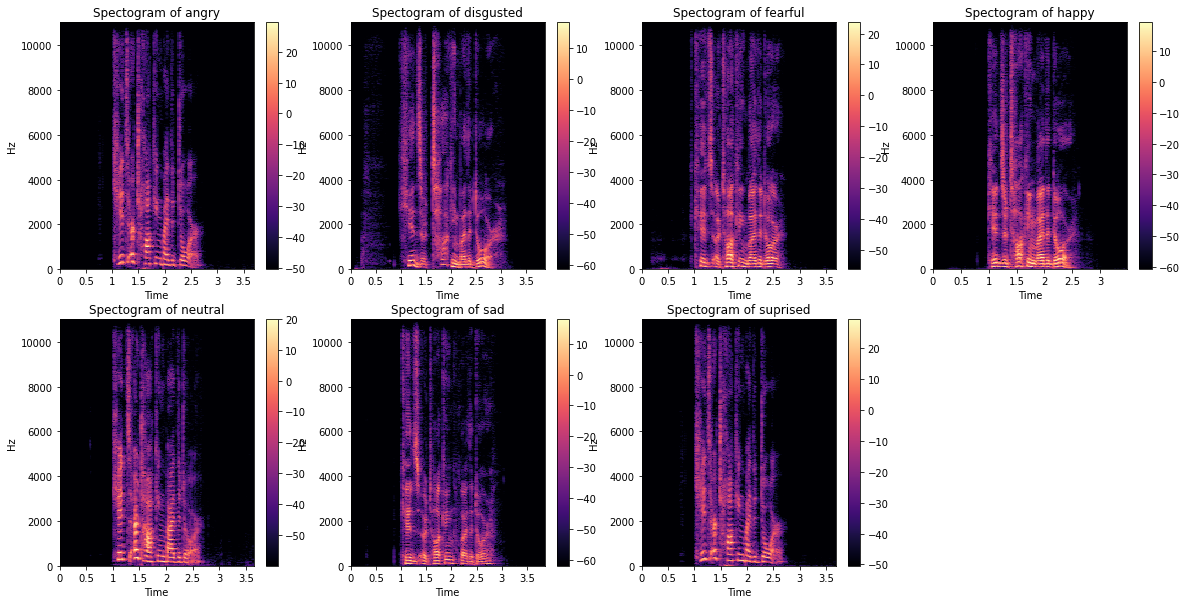

In [20]:
X_angry = librosa.stft(x_angry)
X_disgusted = librosa.stft(x_disgusted)
X_fearful= librosa.stft(x_fearful)
X_happy = librosa.stft(x_happy)
X_neutral = librosa.stft(x_neutral)
X_sad = librosa.stft(x_sad)
X_suprised = librosa.stft(x_suprised)



Xdb1 = librosa.amplitude_to_db(abs(X_angry))
Xdb2= librosa.amplitude_to_db(abs(X_disgusted))
Xdb3 = librosa.amplitude_to_db(abs(X_fearful))
Xdb4 = librosa.amplitude_to_db(abs(X_happy))
Xdb5 = librosa.amplitude_to_db(abs(X_neutral))
Xdb6 = librosa.amplitude_to_db(abs(X_sad))
Xdb7 = librosa.amplitude_to_db(abs(X_suprised))


plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
librosa.display.specshow(data=Xdb1, sr=sr_angry, x_axis='time', y_axis='hz')
plt.title("Spectogram of angry")
plt.colorbar()

plt.subplot(2, 4, 2)
librosa.display.specshow(data=Xdb2, sr=sr_disgusted, x_axis='time', y_axis='hz')
plt.title("Spectogram of disgusted")
plt.colorbar()

plt.subplot(2, 4, 3)
librosa.display.specshow(data=Xdb3, sr=sr_fearful, x_axis='time', y_axis='hz')
plt.title("Spectogram of fearful")
plt.colorbar()

plt.subplot(2, 4, 4)
librosa.display.specshow(data=Xdb4, sr=sr_happy, x_axis='time', y_axis='hz')
plt.title("Spectogram of happy")
plt.colorbar()

plt.subplot(2, 4, 5)
librosa.display.specshow(data=Xdb5, sr=sr_neutral, x_axis='time', y_axis='hz')
plt.title("Spectogram of neutral")
plt.colorbar()

plt.subplot(2, 4, 6)
librosa.display.specshow(data=Xdb6, sr=sr_sad, x_axis='time', y_axis='hz')
plt.title("Spectogram of sad")
plt.colorbar()

plt.subplot(2, 4, 7)
librosa.display.specshow(data=Xdb1, sr=sr_suprised, x_axis='time', y_axis='hz')
plt.title("Spectogram of suprised")
plt.colorbar()

Estas gráficas nos permiten ver mejor las frecuencias presentes en los audios. El eje vertical muestra las diferentes frecuencias ( de 0 a 10kHz) y el eje horizontal muestra el tiempo. Los diferentes colores representan el nivel en el dominio del tiempo y de frecuencia.
En este caso, parece que esa relación se da de manera más intensa en el caso de angry, fearful, neutral y surprised.

# Feature extraction

El siguiente paso será el la extraccion de features previa a la clasificación de ls audios. Para ello, se han definido varias funciones que utilizan diferentes métodos para obtener más información sobre los audios de cada clase de emoción:
   * **PCEN:** para la detección robusta y clasificación de eventos acústicos en entornos heterogéneos
   * **Normalize:** para cambiar el volumen general del audio en una cantidad fija para alcanzar un nivel objetivo
   * **Spectral centroids:** para medir el centro de gravedad del espectro
   * **Spectral rolloff:** representa la frecuencia por debajo de la cual un determinado porcentaje de la magnitud de la distribución espectral de la energía espectral que se concentra en un audio, está contenida en este bin y en las ubicaciones por debajo de % determinado.
   * **Melspectrogram:** devuelve las frecuencias centrales de las bandas en Hz y la ubicación de cada ventana de datos en segundos.
   * **Spectral bandwidth:** analiza la extensión de frecuencias en la que se concentra la mayor potencia de la señal.
   * **Chromagram:** todo el espectro se proyecta en 12 contenedores que representan los 12 semitonos distintos (o croma) de la octava musical.
   * **MFCC:** son un pequeño conjunto de características que describen de forma concisa la forma general de una envolvente espectral. 


In [21]:
def PCEN(x, sr):
    s = librosa.feature.melspectrogram(x, 
                                   sr         = sr,
                                   n_mels     = 128,
                                   hop_length = 512,
                                   n_fft      = 2048,
                                   fmin       = 20,
                                   fmax       = sr//2)
 

    pcen_librosa = librosa.core.pcen(s, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
  
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(pcen_librosa, sr=sr, x_axis='time')
    plt.title("PCEN")
    plt.colorbar() 

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def spectral_centroids(x, sr):
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
  
  
    plt.figure(figsize=(5, 5))
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.title("Spectral centroids")
    
def spectral_rolloff(x, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr ,roll_percent=0.99)[0]
  
    plt.figure(figsize=(5, 5))
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.title("Spectral rolloff")

def melspectrogram(x, sr):
    mel = librosa.feature.melspectrogram(x, sr = sr, n_mels=128, fmin=20, fmax=sr//2)
  
  
    plt.figure(figsize=(5, 5))
    
    librosa.display.specshow(mel, sr=sr, x_axis='time')
    plt.xlabel("time")
    plt.colorbar()
    plt.title("Melspectrogram")
def spectral_bandwidth(x, sr):
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr, p=4)[0]
    frames = range(len(spectral_bandwidth_2))
    t = librosa.frames_to_time(frames)
  
    plt.figure(figsize=(5, 5))
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_bandwidth_2), color='r')
    plt.plot(t, normalize(spectral_bandwidth_3), color='g')
    plt.plot(t, normalize(spectral_bandwidth_4), color='y')
    plt.title("Spectral bandwidth")
    plt.legend(('p = 2', 'p = 3', 'p = 4'))
    
def chromagram(x, sr):
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(x, sr =sr, hop_length=hop_length)
  
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title("Chromagram")
    plt.colorbar()
    
    
def MFCC(x,sr):
    mfccs = librosa.feature.mfcc(x, sr=sr)
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title("MFCC")

Una vez se tienen definidas las funciones, se procede a representar las gráficas para cada audio:

### Happy

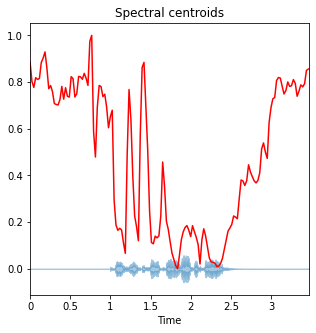

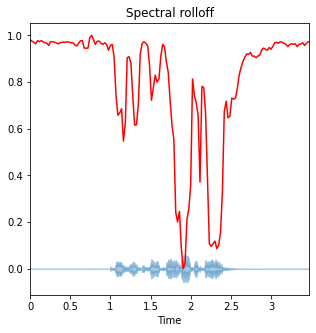

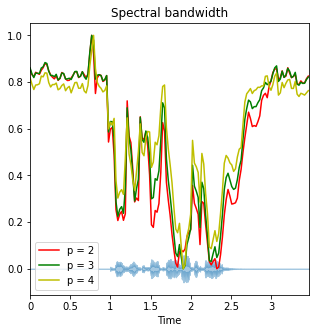

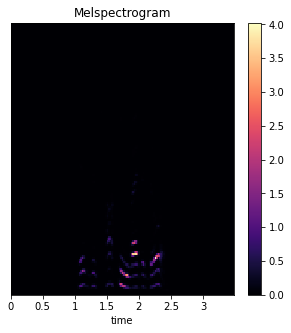

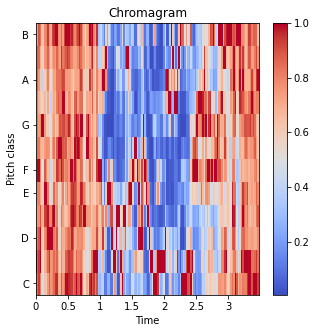

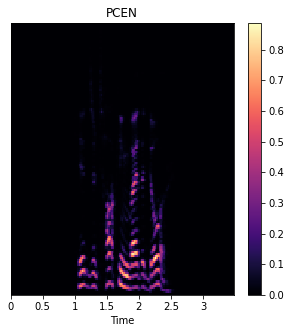

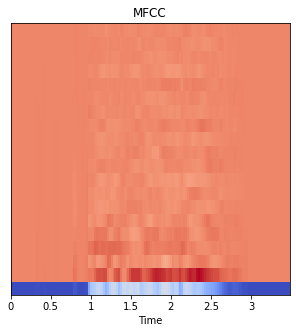

In [13]:
normalize(x_happy)
spectral_centroids(x_happy, sr_happy)
spectral_rolloff(x_happy, sr_happy)
spectral_bandwidth(x_happy, sr_happy)
melspectrogram(x_happy, sr_happy)
chromagram(x_happy, sr_happy)
PCEN(x_happy, sr_happy)
MFCC(x_happy,sr_happy)


### Sad

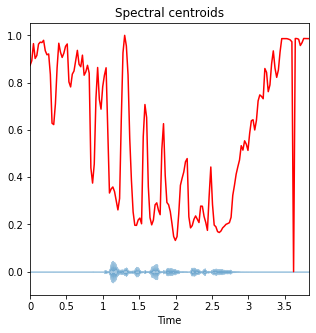

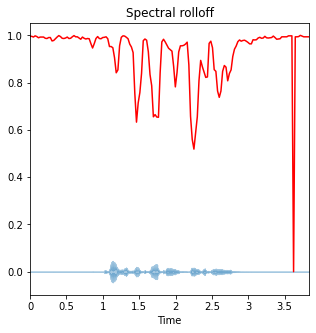

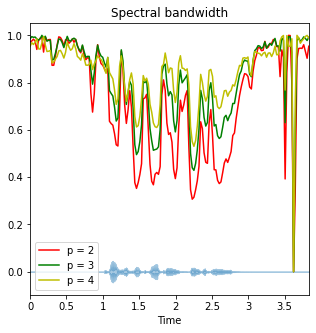

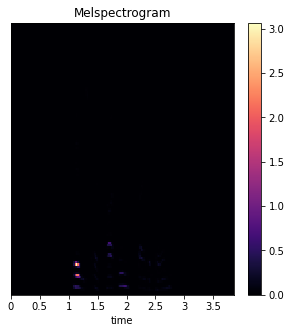

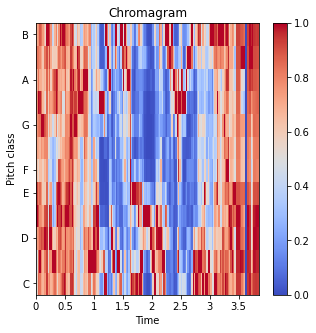

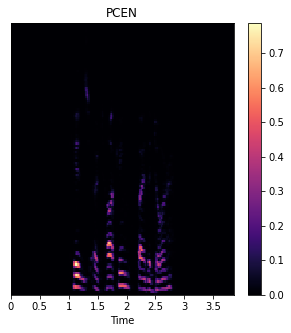

In [14]:
spectral_centroids(x_sad, sr_sad)
spectral_rolloff(x_sad, sr_sad)
spectral_bandwidth(x_sad, sr_sad)
melspectrogram(x_sad, sr_sad)
chromagram(x_sad, sr_sad)
PCEN(x_sad, sr_sad)
play_signal(x_sad, sr_sad)

Por otra parte, se puede ver que en los audios hay segundos de silencio al principio y al final. Para poder analizar mejor las features de las diferentes clases se ha decidido eliminar los segundos de silencio con la función que se presenta a continuación:

In [22]:
#pip install pydub

In [23]:
from pydub import AudioSegment


def removal(files_path,file_name):
    startSec = 1


    endSec = 3

    # Time to miliseconds
    startTime = startSec*1000
    endTime = endSec*1000

    # Opening file and extracting segment
    song = AudioSegment.from_mp3( files_path+file_name+'.wav' )
    extract = song[startTime:endTime]

    # Saving
    extract.export( file_name+'-extract.wav', format="wav")



In [24]:
removal('./Emotions/Angry/','03-01-05-01-01-01-02')
x_angry2 , sr_angry2 = librosa.load('03-01-05-01-01-01-02-extract.wav',sr=22050)
play_signal(x_angry2, sr_angry2)

Una vez hemos conseguido eliminar los silencios se vuelven a extraer lso features en este caso de un audio perteneciente a la clase angry.

### Angry

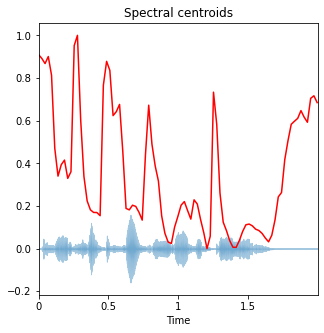

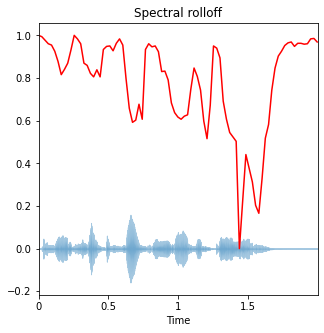

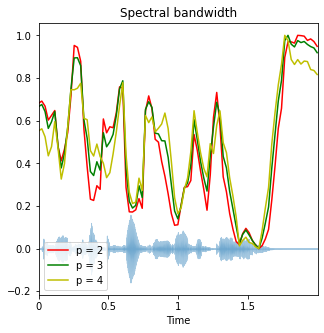

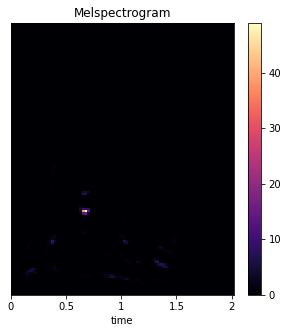

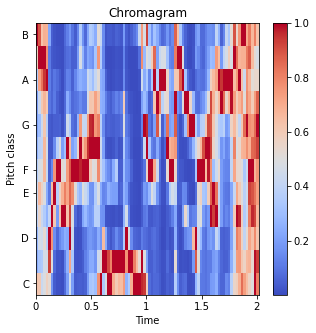

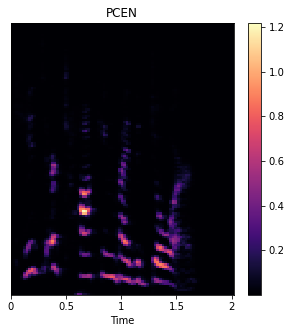

In [59]:
normalize(x_angry2)
spectral_centroids(x_angry2, sr_angry2)
spectral_rolloff(x_angry2, sr_angry2)
spectral_bandwidth(x_angry2, sr_angry2)
melspectrogram(x_angry2, sr_angry2)
chromagram(x_angry2, sr_angry2)
PCEN(x_angry2, sr_angry2)

Las gráficas obtenidas en este caso permiten un mejor análisis ya que al eliminar el silencio inicial de ellas, las gráficas están más extendidas y representan simplemente lo importante del audio en cuestión, el sonido.

### CLASSIFICATION

Para el problema de clasificación, se decide entrenar una red neuronal haciendo uno de la libreria keras sobre Tensorflow.

In [25]:

X, y = zip(*lst)
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


x_traincnn = np.expand_dims(X_train, axis=2) 
x_testcnn = np.expand_dims(X_test, axis=2)

In [17]:
#pip install keras

In [28]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

Para ello, se emplea una capa de aplanamiento (flatten) pra convertir los elementos de entrada en un array plano. 
A continuación, se añaden 3 capas ocultas Dense. Para la función de activación usaremos en las capas ocultas ReLu y
para la capa de salida SoftMax.

Una vez definido el modelo, lo compilamos especificando la función de optimización, la de pérdida y las métricas que usaremos. En este caso, usaremos la función de optimización de descenso de gradiente estocástico, la función de pérdida de entropía cruzada (categorical cross entropy) y, para las métricas, accuracy (o tasa de acierto) y mse (media de los errores cuadráticos).

In [29]:
#Simple model

model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(40, 1)),

        # 1st dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(0.5),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),

        # 3rd dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', 'mse'])

Se entrena un primer modelo con un batch size de 64 y 100 épocas (nº de vueltas completas):

In [30]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=64, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
180/180 [==============================] - 3s 7ms/step - loss: 88.8816 - accuracy: 0.0296 - mse: 9.9446 - val_loss: 32.8238 - val_accuracy: 0.0000e+00 - val_mse: 9.5765
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 63.1770 - accuracy: 0.0729 - mse: 9.9915 - val_loss: 20.3249 - val_accuracy: 0.0617 - val_mse: 9.5606
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 51.5127 - accuracy: 0.1067 - mse: 10.0674 - val_loss: 17.4562 - val_accuracy: 0.1750 - val_mse: 9.5631
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 45.6506 - accuracy: 0.1187 - mse: 9.9864 - val_loss: 16.3800 - val_accuracy: 0.1805 - val_mse: 9.5617
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 41.0746 - accuracy: 0.1299 - mse: 10.1375 - val_loss: 15.4599 - val_accuracy: 0.1813 - val_mse: 9.5608
Epoch 6/100
180/180 [==============================] - 1s 4ms/step - loss: 37.3528 - accuracy: 0.1406 - mse: 

180/180 [==============================] - 1s 5ms/step - loss: 4.0024 - accuracy: 0.1684 - mse: 10.0075 - val_loss: 4.0614 - val_accuracy: 0.1828 - val_mse: 9.4875
Epoch 94/100
180/180 [==============================] - 1s 5ms/step - loss: 3.9652 - accuracy: 0.1678 - mse: 9.9323 - val_loss: 4.0270 - val_accuracy: 0.1813 - val_mse: 9.4875
Epoch 95/100
180/180 [==============================] - 1s 6ms/step - loss: 3.9489 - accuracy: 0.1617 - mse: 9.9464 - val_loss: 3.9902 - val_accuracy: 0.1633 - val_mse: 9.4876
Epoch 96/100
180/180 [==============================] - 1s 5ms/step - loss: 3.9102 - accuracy: 0.1643 - mse: 9.9625 - val_loss: 3.9626 - val_accuracy: 0.1727 - val_mse: 9.4876
Epoch 97/100
180/180 [==============================] - 1s 4ms/step - loss: 3.8878 - accuracy: 0.1674 - mse: 10.0118 - val_loss: 3.9317 - val_accuracy: 0.1672 - val_mse: 9.4876
Epoch 98/100
180/180 [==============================] - 1s 4ms/step - loss: 3.8355 - accuracy: 0.1697 - mse: 9.9478 - val_loss: 3.9

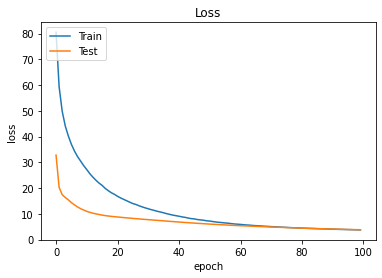

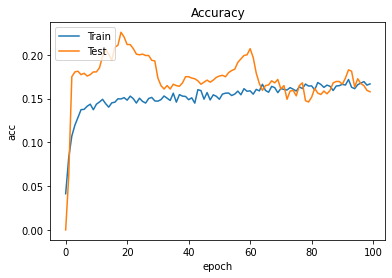

In [31]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Se entrena un nuevo modelo aumentando el batch size y el nº de épocas.

In [45]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=100, epochs=2000, validation_data=(x_testcnn, y_test))

Epoch 1/2000
116/116 [==============================] - 3s 14ms/step - loss: 1.1411 - accuracy: 0.6082 - mse: 10.0162 - val_loss: 1.1167 - val_accuracy: 0.6094 - val_mse: 9.5248
Epoch 2/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1329 - accuracy: 0.6114 - mse: 10.0162 - val_loss: 1.1180 - val_accuracy: 0.6133 - val_mse: 9.5248
Epoch 3/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1334 - accuracy: 0.6124 - mse: 10.0164 - val_loss: 1.1194 - val_accuracy: 0.6125 - val_mse: 9.5247
Epoch 4/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1397 - accuracy: 0.6097 - mse: 10.0160 - val_loss: 1.1194 - val_accuracy: 0.6125 - val_mse: 9.5249
Epoch 5/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1420 - accuracy: 0.6026 - mse: 10.0161 - val_loss: 1.1180 - val_accuracy: 0.6102 - val_mse: 9.5247
Epoch 6/2000
116/116 [==============================] - 1s 7ms/step - loss: 1.1403 - accuracy: 0.6074 - mse: 10.01

116/116 [==============================] - 1s 5ms/step - loss: 1.1396 - accuracy: 0.6085 - mse: 10.0162 - val_loss: 1.1174 - val_accuracy: 0.6070 - val_mse: 9.5250
Epoch 48/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1325 - accuracy: 0.6109 - mse: 10.0164 - val_loss: 1.1163 - val_accuracy: 0.6117 - val_mse: 9.5251
Epoch 49/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1360 - accuracy: 0.6057 - mse: 10.0164 - val_loss: 1.1188 - val_accuracy: 0.6094 - val_mse: 9.5250
Epoch 50/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1353 - accuracy: 0.6123 - mse: 10.0163 - val_loss: 1.1156 - val_accuracy: 0.6109 - val_mse: 9.5250
Epoch 51/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1294 - accuracy: 0.6105 - mse: 10.0164 - val_loss: 1.1173 - val_accuracy: 0.6117 - val_mse: 9.5249
Epoch 52/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1315 - accuracy: 0.6099 - mse: 10.0164 - val_

Epoch 139/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1322 - accuracy: 0.6084 - mse: 10.0166 - val_loss: 1.1154 - val_accuracy: 0.6109 - val_mse: 9.5256
Epoch 140/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1355 - accuracy: 0.6074 - mse: 10.0166 - val_loss: 1.1091 - val_accuracy: 0.6180 - val_mse: 9.5252
Epoch 141/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1308 - accuracy: 0.6089 - mse: 10.0165 - val_loss: 1.1110 - val_accuracy: 0.6117 - val_mse: 9.5254
Epoch 142/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1281 - accuracy: 0.6101 - mse: 10.0167 - val_loss: 1.1070 - val_accuracy: 0.6141 - val_mse: 9.5252
Epoch 143/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1259 - accuracy: 0.6146 - mse: 10.0167 - val_loss: 1.1102 - val_accuracy: 0.6094 - val_mse: 9.5253
Epoch 144/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1250 - accuracy: 0.6175 -

Epoch 185/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1243 - accuracy: 0.6122 - mse: 10.0169 - val_loss: 1.1111 - val_accuracy: 0.6172 - val_mse: 9.5256
Epoch 186/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1231 - accuracy: 0.6205 - mse: 10.0168 - val_loss: 1.1093 - val_accuracy: 0.6086 - val_mse: 9.5257
Epoch 187/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1210 - accuracy: 0.6161 - mse: 10.0169 - val_loss: 1.1101 - val_accuracy: 0.6125 - val_mse: 9.5255
Epoch 188/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1227 - accuracy: 0.6136 - mse: 10.0169 - val_loss: 1.1112 - val_accuracy: 0.6141 - val_mse: 9.5256
Epoch 189/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1168 - accuracy: 0.6148 - mse: 10.0169 - val_loss: 1.1077 - val_accuracy: 0.6117 - val_mse: 9.5254
Epoch 190/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1273 - accuracy: 0.6105 -

Epoch 231/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1131 - accuracy: 0.6181 - mse: 10.0171 - val_loss: 1.1063 - val_accuracy: 0.6102 - val_mse: 9.5255
Epoch 232/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1197 - accuracy: 0.6171 - mse: 10.0168 - val_loss: 1.1023 - val_accuracy: 0.6195 - val_mse: 9.5260
Epoch 233/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1193 - accuracy: 0.6157 - mse: 10.0170 - val_loss: 1.1073 - val_accuracy: 0.6133 - val_mse: 9.5256
Epoch 234/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1228 - accuracy: 0.6159 - mse: 10.0168 - val_loss: 1.1073 - val_accuracy: 0.6141 - val_mse: 9.5257
Epoch 235/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1213 - accuracy: 0.6170 - mse: 10.0170 - val_loss: 1.1061 - val_accuracy: 0.6187 - val_mse: 9.5259
Epoch 236/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1241 - accuracy: 0.6140 -

Epoch 277/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1187 - accuracy: 0.6195 - mse: 10.0170 - val_loss: 1.1073 - val_accuracy: 0.6172 - val_mse: 9.5256
Epoch 278/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1233 - accuracy: 0.6155 - mse: 10.0171 - val_loss: 1.1033 - val_accuracy: 0.6203 - val_mse: 9.5258
Epoch 279/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1170 - accuracy: 0.6206 - mse: 10.0171 - val_loss: 1.1044 - val_accuracy: 0.6148 - val_mse: 9.5256
Epoch 280/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1158 - accuracy: 0.6194 - mse: 10.0169 - val_loss: 1.1053 - val_accuracy: 0.6109 - val_mse: 9.5260
Epoch 281/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1212 - accuracy: 0.6162 - mse: 10.0170 - val_loss: 1.1049 - val_accuracy: 0.6102 - val_mse: 9.5257
Epoch 282/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1218 - accuracy: 0.6152 -

Epoch 323/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1152 - accuracy: 0.6219 - mse: 10.0173 - val_loss: 1.1030 - val_accuracy: 0.6172 - val_mse: 9.5258
Epoch 324/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1174 - accuracy: 0.6177 - mse: 10.0170 - val_loss: 1.1014 - val_accuracy: 0.6164 - val_mse: 9.5259
Epoch 325/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1107 - accuracy: 0.6214 - mse: 10.0174 - val_loss: 1.1046 - val_accuracy: 0.6195 - val_mse: 9.5258
Epoch 326/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1157 - accuracy: 0.6187 - mse: 10.0173 - val_loss: 1.1055 - val_accuracy: 0.6180 - val_mse: 9.5262
Epoch 327/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1111 - accuracy: 0.6190 - mse: 10.0172 - val_loss: 1.1017 - val_accuracy: 0.6156 - val_mse: 9.5260
Epoch 328/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1133 - accuracy: 0.6202 -

Epoch 369/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1044 - accuracy: 0.6283 - mse: 10.0174 - val_loss: 1.1019 - val_accuracy: 0.6133 - val_mse: 9.5260
Epoch 370/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1138 - accuracy: 0.6224 - mse: 10.0173 - val_loss: 1.0980 - val_accuracy: 0.6234 - val_mse: 9.5263
Epoch 371/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1044 - accuracy: 0.6268 - mse: 10.0175 - val_loss: 1.0979 - val_accuracy: 0.6281 - val_mse: 9.5262
Epoch 372/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1139 - accuracy: 0.6193 - mse: 10.0174 - val_loss: 1.1017 - val_accuracy: 0.6203 - val_mse: 9.5260
Epoch 373/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1132 - accuracy: 0.6156 - mse: 10.0173 - val_loss: 1.0998 - val_accuracy: 0.6234 - val_mse: 9.5260
Epoch 374/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1182 - accuracy: 0.6172 -

Epoch 415/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1105 - accuracy: 0.6234 - mse: 10.0173 - val_loss: 1.0969 - val_accuracy: 0.6141 - val_mse: 9.5261
Epoch 416/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1080 - accuracy: 0.6229 - mse: 10.0176 - val_loss: 1.0978 - val_accuracy: 0.6195 - val_mse: 9.5263
Epoch 417/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1158 - accuracy: 0.6201 - mse: 10.0174 - val_loss: 1.0990 - val_accuracy: 0.6242 - val_mse: 9.5262
Epoch 418/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1079 - accuracy: 0.6197 - mse: 10.0173 - val_loss: 1.0975 - val_accuracy: 0.6227 - val_mse: 9.5264
Epoch 419/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1068 - accuracy: 0.6243 - mse: 10.0177 - val_loss: 1.0987 - val_accuracy: 0.6187 - val_mse: 9.5263
Epoch 420/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1110 - accuracy: 0.6214 -

Epoch 461/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1078 - accuracy: 0.6182 - mse: 10.0178 - val_loss: 1.0956 - val_accuracy: 0.6242 - val_mse: 9.5262
Epoch 462/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1106 - accuracy: 0.6234 - mse: 10.0175 - val_loss: 1.0949 - val_accuracy: 0.6227 - val_mse: 9.5263
Epoch 463/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1015 - accuracy: 0.6237 - mse: 10.0177 - val_loss: 1.0946 - val_accuracy: 0.6203 - val_mse: 9.5262
Epoch 464/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1035 - accuracy: 0.6236 - mse: 10.0176 - val_loss: 1.0968 - val_accuracy: 0.6203 - val_mse: 9.5264
Epoch 465/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1039 - accuracy: 0.6239 - mse: 10.0178 - val_loss: 1.0960 - val_accuracy: 0.6289 - val_mse: 9.5264
Epoch 466/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1095 - accuracy: 0.6224 -

Epoch 507/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1042 - accuracy: 0.6229 - mse: 10.0177 - val_loss: 1.0949 - val_accuracy: 0.6258 - val_mse: 9.5265
Epoch 508/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1075 - accuracy: 0.6221 - mse: 10.0177 - val_loss: 1.0961 - val_accuracy: 0.6266 - val_mse: 9.5264
Epoch 509/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1025 - accuracy: 0.6235 - mse: 10.0178 - val_loss: 1.0994 - val_accuracy: 0.6242 - val_mse: 9.5266
Epoch 510/2000
116/116 [==============================] - ETA: 0s - loss: 1.0997 - accuracy: 0.6252 - mse: 10.021 - 1s 5ms/step - loss: 1.1000 - accuracy: 0.6259 - mse: 10.0178 - val_loss: 1.0954 - val_accuracy: 0.6187 - val_mse: 9.5263
Epoch 511/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0998 - accuracy: 0.6249 - mse: 10.0177 - val_loss: 1.0964 - val_accuracy: 0.6219 - val_mse: 9.5270
Epoch 512/2000
116/116 [=======================

Epoch 598/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0939 - accuracy: 0.6286 - mse: 10.0180 - val_loss: 1.0938 - val_accuracy: 0.6289 - val_mse: 9.5270
Epoch 599/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1018 - accuracy: 0.6214 - mse: 10.0178 - val_loss: 1.0912 - val_accuracy: 0.6281 - val_mse: 9.5268
Epoch 600/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0966 - accuracy: 0.6298 - mse: 10.0179 - val_loss: 1.0935 - val_accuracy: 0.6289 - val_mse: 9.5269
Epoch 601/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0991 - accuracy: 0.6272 - mse: 10.0180 - val_loss: 1.0912 - val_accuracy: 0.6227 - val_mse: 9.5265
Epoch 602/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.1010 - accuracy: 0.6258 - mse: 10.0177 - val_loss: 1.0906 - val_accuracy: 0.6281 - val_mse: 9.5269
Epoch 603/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0940 - accuracy: 0.6274 -

Epoch 644/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0962 - accuracy: 0.6239 - mse: 10.0181 - val_loss: 1.0915 - val_accuracy: 0.6250 - val_mse: 9.5268
Epoch 645/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0900 - accuracy: 0.6305 - mse: 10.0181 - val_loss: 1.0888 - val_accuracy: 0.6281 - val_mse: 9.5268
Epoch 646/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0984 - accuracy: 0.6252 - mse: 10.0180 - val_loss: 1.0913 - val_accuracy: 0.6250 - val_mse: 9.5268
Epoch 647/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.1000 - accuracy: 0.6238 - mse: 10.0181 - val_loss: 1.0917 - val_accuracy: 0.6242 - val_mse: 9.5268
Epoch 648/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0862 - accuracy: 0.6311 - mse: 10.0180 - val_loss: 1.0902 - val_accuracy: 0.6313 - val_mse: 9.5270
Epoch 649/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0899 - accuracy: 0.6299 -

Epoch 690/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0998 - accuracy: 0.6259 - mse: 10.0183 - val_loss: 1.0898 - val_accuracy: 0.6211 - val_mse: 9.5271
Epoch 691/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0905 - accuracy: 0.6274 - mse: 10.0183 - val_loss: 1.0881 - val_accuracy: 0.6258 - val_mse: 9.5270
Epoch 692/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0983 - accuracy: 0.6223 - mse: 10.0182 - val_loss: 1.0887 - val_accuracy: 0.6187 - val_mse: 9.5266
Epoch 693/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0944 - accuracy: 0.6278 - mse: 10.0180 - val_loss: 1.0878 - val_accuracy: 0.6266 - val_mse: 9.5267
Epoch 694/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0944 - accuracy: 0.6284 - mse: 10.0182 - val_loss: 1.0871 - val_accuracy: 0.6367 - val_mse: 9.5271
Epoch 695/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0912 - accuracy: 0.6290 -

Epoch 736/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0851 - accuracy: 0.6349 - mse: 10.0184 - val_loss: 1.0851 - val_accuracy: 0.6305 - val_mse: 9.5272
Epoch 737/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0913 - accuracy: 0.6274 - mse: 10.0183 - val_loss: 1.0855 - val_accuracy: 0.6297 - val_mse: 9.5272
Epoch 738/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0889 - accuracy: 0.6313 - mse: 10.0183 - val_loss: 1.0861 - val_accuracy: 0.6367 - val_mse: 9.5269
Epoch 739/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0903 - accuracy: 0.6289 - mse: 10.0182 - val_loss: 1.0874 - val_accuracy: 0.6289 - val_mse: 9.5269
Epoch 740/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0854 - accuracy: 0.6321 - mse: 10.0184 - val_loss: 1.0885 - val_accuracy: 0.6266 - val_mse: 9.5270
Epoch 741/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0836 - accuracy: 0.6341 -

Epoch 782/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0826 - accuracy: 0.6371 - mse: 10.0185 - val_loss: 1.0838 - val_accuracy: 0.6242 - val_mse: 9.5274
Epoch 783/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0837 - accuracy: 0.6310 - mse: 10.0187 - val_loss: 1.0846 - val_accuracy: 0.6203 - val_mse: 9.5272
Epoch 784/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0871 - accuracy: 0.6324 - mse: 10.0186 - val_loss: 1.0835 - val_accuracy: 0.6266 - val_mse: 9.5270
Epoch 785/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0841 - accuracy: 0.6366 - mse: 10.0185 - val_loss: 1.0864 - val_accuracy: 0.6273 - val_mse: 9.5272
Epoch 786/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0849 - accuracy: 0.6334 - mse: 10.0187 - val_loss: 1.0841 - val_accuracy: 0.6242 - val_mse: 9.5271
Epoch 787/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0907 - accuracy: 0.6306 -

Epoch 828/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0832 - accuracy: 0.6314 - mse: 10.0185 - val_loss: 1.0839 - val_accuracy: 0.6344 - val_mse: 9.5274
Epoch 829/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0814 - accuracy: 0.6354 - mse: 10.0185 - val_loss: 1.0811 - val_accuracy: 0.6273 - val_mse: 9.5272
Epoch 830/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0862 - accuracy: 0.6348 - mse: 10.0184 - val_loss: 1.0819 - val_accuracy: 0.6289 - val_mse: 9.5271
Epoch 831/2000
116/116 [==============================] - ETA: 0s - loss: 1.0833 - accuracy: 0.6350 - mse: 10.008 - 1s 6ms/step - loss: 1.0841 - accuracy: 0.6356 - mse: 10.0183 - val_loss: 1.0865 - val_accuracy: 0.6313 - val_mse: 9.5274
Epoch 832/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0873 - accuracy: 0.6345 - mse: 10.0183 - val_loss: 1.0806 - val_accuracy: 0.6297 - val_mse: 9.5273
Epoch 833/2000
116/116 [=======================

Epoch 919/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0832 - accuracy: 0.6350 - mse: 10.0187 - val_loss: 1.0779 - val_accuracy: 0.6367 - val_mse: 9.5275
Epoch 920/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0822 - accuracy: 0.6316 - mse: 10.0188 - val_loss: 1.0836 - val_accuracy: 0.6281 - val_mse: 9.5273
Epoch 921/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0863 - accuracy: 0.6301 - mse: 10.0186 - val_loss: 1.0848 - val_accuracy: 0.6289 - val_mse: 9.5277
Epoch 922/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0850 - accuracy: 0.6346 - mse: 10.0185 - val_loss: 1.0826 - val_accuracy: 0.6187 - val_mse: 9.5274
Epoch 923/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0776 - accuracy: 0.6373 - mse: 10.0186 - val_loss: 1.0769 - val_accuracy: 0.6250 - val_mse: 9.5273
Epoch 924/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0814 - accuracy: 0.6332 -

Epoch 965/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0784 - accuracy: 0.6340 - mse: 10.0189 - val_loss: 1.0802 - val_accuracy: 0.6328 - val_mse: 9.5275
Epoch 966/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0745 - accuracy: 0.6364 - mse: 10.0189 - val_loss: 1.0799 - val_accuracy: 0.6328 - val_mse: 9.5275
Epoch 967/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0738 - accuracy: 0.6366 - mse: 10.0189 - val_loss: 1.0770 - val_accuracy: 0.6352 - val_mse: 9.5277
Epoch 968/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0823 - accuracy: 0.6318 - mse: 10.0187 - val_loss: 1.0768 - val_accuracy: 0.6398 - val_mse: 9.5273
Epoch 969/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0845 - accuracy: 0.6341 - mse: 10.0187 - val_loss: 1.0834 - val_accuracy: 0.6234 - val_mse: 9.5277
Epoch 970/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0832 - accuracy: 0.6312 -

116/116 [==============================] - 1s 7ms/step - loss: 1.0803 - accuracy: 0.6343 - mse: 10.0189 - val_loss: 1.0780 - val_accuracy: 0.6258 - val_mse: 9.5277
Epoch 1056/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0737 - accuracy: 0.6365 - mse: 10.0190 - val_loss: 1.0761 - val_accuracy: 0.6273 - val_mse: 9.5278
Epoch 1057/2000
116/116 [==============================] - 1s 7ms/step - loss: 1.0743 - accuracy: 0.6369 - mse: 10.0192 - val_loss: 1.0755 - val_accuracy: 0.6313 - val_mse: 9.5279
Epoch 1058/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0767 - accuracy: 0.6339 - mse: 10.0191 - val_loss: 1.0752 - val_accuracy: 0.6367 - val_mse: 9.5277
Epoch 1059/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0854 - accuracy: 0.6313 - mse: 10.0188 - val_loss: 1.0782 - val_accuracy: 0.6297 - val_mse: 9.5277
Epoch 1060/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0774 - accuracy: 0.6319 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0686 - accuracy: 0.6453 - mse: 10.0193 - val_loss: 1.0702 - val_accuracy: 0.6344 - val_mse: 9.5279
Epoch 1146/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0761 - accuracy: 0.6379 - mse: 10.0191 - val_loss: 1.0708 - val_accuracy: 0.6414 - val_mse: 9.5279
Epoch 1147/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0643 - accuracy: 0.6412 - mse: 10.0192 - val_loss: 1.0768 - val_accuracy: 0.6336 - val_mse: 9.5278
Epoch 1148/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0714 - accuracy: 0.6393 - mse: 10.0193 - val_loss: 1.0725 - val_accuracy: 0.6391 - val_mse: 9.5278
Epoch 1149/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0715 - accuracy: 0.6376 - mse: 10.0191 - val_loss: 1.0716 - val_accuracy: 0.6313 - val_mse: 9.5279
Epoch 1150/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0706 - accuracy: 0.6389 - mse: 10.0

116/116 [==============================] - 1s 7ms/step - loss: 1.0702 - accuracy: 0.6410 - mse: 10.0193 - val_loss: 1.0700 - val_accuracy: 0.6391 - val_mse: 9.5281
Epoch 1236/2000
116/116 [==============================] - 1s 7ms/step - loss: 1.0694 - accuracy: 0.6428 - mse: 10.0194 - val_loss: 1.0705 - val_accuracy: 0.6477 - val_mse: 9.5282
Epoch 1237/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0674 - accuracy: 0.6417 - mse: 10.0194 - val_loss: 1.0728 - val_accuracy: 0.6313 - val_mse: 9.5284
Epoch 1238/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0664 - accuracy: 0.6391 - mse: 10.0195 - val_loss: 1.0695 - val_accuracy: 0.6430 - val_mse: 9.5280
Epoch 1239/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0667 - accuracy: 0.6367 - mse: 10.0193 - val_loss: 1.0701 - val_accuracy: 0.6391 - val_mse: 9.5283
Epoch 1240/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0611 - accuracy: 0.6412 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0581 - accuracy: 0.6458 - mse: 10.0196 - val_loss: 1.0640 - val_accuracy: 0.6477 - val_mse: 9.5279
Epoch 1326/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0625 - accuracy: 0.6470 - mse: 10.0196 - val_loss: 1.0672 - val_accuracy: 0.6391 - val_mse: 9.5284
Epoch 1327/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0580 - accuracy: 0.6460 - mse: 10.0197 - val_loss: 1.0662 - val_accuracy: 0.6430 - val_mse: 9.5285
Epoch 1328/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0611 - accuracy: 0.6446 - mse: 10.0197 - val_loss: 1.0655 - val_accuracy: 0.6445 - val_mse: 9.5285
Epoch 1329/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0711 - accuracy: 0.6389 - mse: 10.0194 - val_loss: 1.0662 - val_accuracy: 0.6398 - val_mse: 9.5279
Epoch 1330/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0614 - accuracy: 0.6404 - mse: 10.0

116/116 [==============================] - 1s 6ms/step - loss: 1.0612 - accuracy: 0.6428 - mse: 10.0197 - val_loss: 1.0645 - val_accuracy: 0.6492 - val_mse: 9.5286
Epoch 1416/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0560 - accuracy: 0.6485 - mse: 10.0196 - val_loss: 1.0655 - val_accuracy: 0.6367 - val_mse: 9.5284
Epoch 1417/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0569 - accuracy: 0.6426 - mse: 10.0197 - val_loss: 1.0667 - val_accuracy: 0.6469 - val_mse: 9.5284
Epoch 1418/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0588 - accuracy: 0.6427 - mse: 10.0199 - val_loss: 1.0639 - val_accuracy: 0.6445 - val_mse: 9.5283
Epoch 1419/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0639 - accuracy: 0.6370 - mse: 10.0196 - val_loss: 1.0640 - val_accuracy: 0.6500 - val_mse: 9.5284
Epoch 1420/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0614 - accuracy: 0.6449 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0507 - accuracy: 0.6517 - mse: 10.0200 - val_loss: 1.0616 - val_accuracy: 0.6414 - val_mse: 9.5286
Epoch 1506/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0540 - accuracy: 0.6416 - mse: 10.0198 - val_loss: 1.0623 - val_accuracy: 0.6547 - val_mse: 9.5286
Epoch 1507/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0484 - accuracy: 0.6519 - mse: 10.0199 - val_loss: 1.0658 - val_accuracy: 0.6469 - val_mse: 9.5286
Epoch 1508/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0546 - accuracy: 0.6457 - mse: 10.0199 - val_loss: 1.0645 - val_accuracy: 0.6484 - val_mse: 9.5289
Epoch 1509/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0482 - accuracy: 0.6488 - mse: 10.0200 - val_loss: 1.0589 - val_accuracy: 0.6500 - val_mse: 9.5287
Epoch 1510/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0543 - accuracy: 0.6453 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0497 - accuracy: 0.6486 - mse: 10.0201 - val_loss: 1.0603 - val_accuracy: 0.6484 - val_mse: 9.5288
Epoch 1596/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0504 - accuracy: 0.6518 - mse: 10.0201 - val_loss: 1.0641 - val_accuracy: 0.6445 - val_mse: 9.5289
Epoch 1597/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0519 - accuracy: 0.6464 - mse: 10.0200 - val_loss: 1.0615 - val_accuracy: 0.6484 - val_mse: 9.5292
Epoch 1598/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0581 - accuracy: 0.6429 - mse: 10.0201 - val_loss: 1.0626 - val_accuracy: 0.6422 - val_mse: 9.5285
Epoch 1599/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0541 - accuracy: 0.6432 - mse: 10.0199 - val_loss: 1.0595 - val_accuracy: 0.6523 - val_mse: 9.5290
Epoch 1600/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0475 - accuracy: 0.6495 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0457 - accuracy: 0.6486 - mse: 10.0201 - val_loss: 1.0611 - val_accuracy: 0.6422 - val_mse: 9.5291
Epoch 1686/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0479 - accuracy: 0.6504 - mse: 10.0201 - val_loss: 1.0589 - val_accuracy: 0.6375 - val_mse: 9.5288
Epoch 1687/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0451 - accuracy: 0.6446 - mse: 10.0201 - val_loss: 1.0584 - val_accuracy: 0.6531 - val_mse: 9.5289
Epoch 1688/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0467 - accuracy: 0.6472 - mse: 10.0204 - val_loss: 1.0580 - val_accuracy: 0.6422 - val_mse: 9.5289
Epoch 1689/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0478 - accuracy: 0.6515 - mse: 10.0202 - val_loss: 1.0616 - val_accuracy: 0.6469 - val_mse: 9.5289
Epoch 1690/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0525 - accuracy: 0.6479 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0500 - accuracy: 0.6468 - mse: 10.0203 - val_loss: 1.0573 - val_accuracy: 0.6461 - val_mse: 9.5289
Epoch 1776/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0478 - accuracy: 0.6453 - mse: 10.0202 - val_loss: 1.0549 - val_accuracy: 0.6492 - val_mse: 9.5289
Epoch 1777/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0475 - accuracy: 0.6447 - mse: 10.0202 - val_loss: 1.0574 - val_accuracy: 0.6438 - val_mse: 9.5293
Epoch 1778/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0444 - accuracy: 0.6467 - mse: 10.0204 - val_loss: 1.0578 - val_accuracy: 0.6531 - val_mse: 9.5292
Epoch 1779/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0400 - accuracy: 0.6492 - mse: 10.0204 - val_loss: 1.0567 - val_accuracy: 0.6453 - val_mse: 9.5292
Epoch 1780/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0452 - accuracy: 0.6469 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0463 - accuracy: 0.6519 - mse: 10.0207 - val_loss: 1.0565 - val_accuracy: 0.6500 - val_mse: 9.5288
Epoch 1866/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0400 - accuracy: 0.6532 - mse: 10.0204 - val_loss: 1.0532 - val_accuracy: 0.6523 - val_mse: 9.5291
Epoch 1867/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0399 - accuracy: 0.6478 - mse: 10.0204 - val_loss: 1.0535 - val_accuracy: 0.6508 - val_mse: 9.5294
Epoch 1868/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0430 - accuracy: 0.6493 - mse: 10.0205 - val_loss: 1.0560 - val_accuracy: 0.6469 - val_mse: 9.5292
Epoch 1869/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0421 - accuracy: 0.6476 - mse: 10.0203 - val_loss: 1.0567 - val_accuracy: 0.6438 - val_mse: 9.5293
Epoch 1870/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0456 - accuracy: 0.6515 - mse: 10.0

116/116 [==============================] - 1s 5ms/step - loss: 1.0402 - accuracy: 0.6475 - mse: 10.0205 - val_loss: 1.0576 - val_accuracy: 0.6492 - val_mse: 9.5289
Epoch 1956/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0264 - accuracy: 0.6576 - mse: 10.0206 - val_loss: 1.0503 - val_accuracy: 0.6539 - val_mse: 9.5296
Epoch 1957/2000
116/116 [==============================] - 1s 5ms/step - loss: 1.0321 - accuracy: 0.6550 - mse: 10.0209 - val_loss: 1.0560 - val_accuracy: 0.6469 - val_mse: 9.5296
Epoch 1958/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0409 - accuracy: 0.6486 - mse: 10.0207 - val_loss: 1.0561 - val_accuracy: 0.6500 - val_mse: 9.5291
Epoch 1959/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0343 - accuracy: 0.6530 - mse: 10.0207 - val_loss: 1.0525 - val_accuracy: 0.6492 - val_mse: 9.5291
Epoch 1960/2000
116/116 [==============================] - 1s 6ms/step - loss: 1.0402 - accuracy: 0.6534 - mse: 10.0

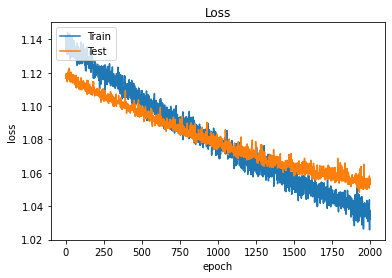

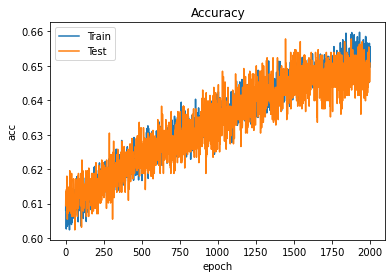

In [50]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### RESULTS

In [51]:
from sklearn.metrics import classification_report

predictions = model.predict_classes(x_testcnn)
y_test2 = y_test.astype(int)
report = classification_report(y_test2, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       221
           1       0.55      0.56      0.56       188
           2       0.67      0.50      0.57       216
           3       0.65      0.64      0.65       222
           4       0.58      0.65      0.61       175
           5       0.63      0.69      0.66       213
           6       0.89      0.89      0.89        45

    accuracy                           0.65      1280
   macro avg       0.67      0.68      0.67      1280
weighted avg       0.65      0.65      0.65      1280



In [52]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test2, predictions)
print (matrix)

[[176   8   5  22   8   2   0]
 [ 12 106   9  15  22  23   1]
 [ 16  18 108  18  12  44   0]
 [ 23  18  20 142  13   4   2]
 [  2  26   7  13 114  13   0]
 [  0  15  13   8  28 147   2]
 [  2   2   0   0   1   0  40]]


El modelo podría mejorarse porque el accuracy no es el óptimo y hay muchos audios que se clasifican mal, pero esto puede deberse a que es muy complicado analizar las emociones en un audio de tan solo 2 segundos. Quizás habría que entrenar un modelo con audios más extensos, dataset más grandes y mejorando y añadiendo capas ocultas a la cnn entrenada.

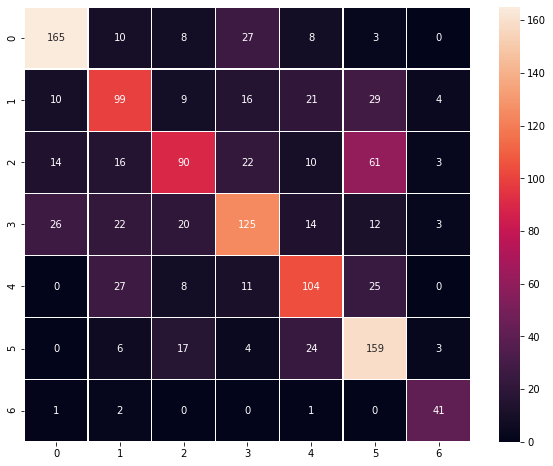

In [39]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d", cbar=True, linewidths=.3);

In [32]:
#comando para salvar el modelo:

model_name = 'EmotionClassificationCNNModel.h5'
save_dir = '/kaggle/working'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working\EmotionClassificationModel.h5 
